# Sentiment Analysis for POTUS Speech Corpus using vaderSentiment

### Imports

In [17]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### Import corpus

In [18]:
import os
import re
df = pd.DataFrame()
_id = 1
for filename in os.listdir('./speeches'):
    if filename == '.DS_Store':
        continue
    for speech in os.listdir('./speeches/' + filename):
        temp = open('./speeches/' + filename + '/' + speech, 'r', encoding='utf-8').readlines()
        obj = {}
        obj['doc_id'] = _id
        date = re.findall('"([^"]*)"', temp[1])
        obj['date'] = date[0] if len(date) > 0 else None
        obj['pres'] = filename
        obj['title'] = re.findall('"([^"]*)"', temp[0])[0]
        obj['speech']= "".join(temp[2:])
        obj['sentiment'] = ""
    
        obj = pd.DataFrame(obj, index=[0])
        df = df.append(obj, ignore_index=True)
        _id += 1
df = df.set_index("doc_id")
df.head()

,date,pres,title,speech,sentiment
doc_id,,,,,
1,"August 10, 1927",coolidge,Address at the Opening of Work on Mount Rushmo...,We have come here to dedicate a cornerstone th...,
2,"December 8, 1925",coolidge,Third Annual Message,Members of the Congress: In meeting the consti...,
3,"December 6, 1923",coolidge,First Annual Message,Since the close of the last Congress the Natio...,
4,"October 20, 1925",coolidge,Message Regarding Relationship of Church and S...,"Mr. Moderator, Members Of The Council:\nIt is ...",
5,"March 4, 1925",coolidge,Inaugural Address,\nMy Countrymen:\n\nNo one can contemplate cur...,


### Get rid of bad characters

In [19]:
for index, row in df.iterrows():
    re.sub("[\<\(\[].*?[\)\]\>]", "", row['speech'])

### Function to split speech into list of sentences

In [20]:
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

### Sentiment analyzer

In [21]:
import operator
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    del score['compound']
    return max(score.items(), key=operator.itemgetter(1))[0]

### Run the sentiment analyzer on the corpus
Individualized by president

In [22]:
from collections import OrderedDict
pres_list = "adams arthur bharrison buchanan bush carter cleveland cleveland2 clinton coolidge eisenhower fdroosevelt fillmore ford garfield grant gwbush harding harrison hayes hoover jackson jefferson johnson jqadams kennedy lbjohnson lincoln madison mckinley monroe nixon obama pierce polk reagan roosevelt taft taylor truman trump tyler vanburen washington wilson".split()
terms = [1797, 1881.5, 1889, 1857, 1989, 1977, 1885, 1893, 1993, 1923, 1953, 1933, 1850, 1974, 1881, 1869, 2001, 1921, 1841.5, 1877, 1929, 1829, 1801, 1865, 1825, 1961, 1963, 1861, 1809, 1897, 1817, 1969, 2009, 1853, 1845, 1981, 1901, 1909, 1849, 1945, 2017, 1841, 1837, 1789, 1913]
pres_terms = list(zip(pres_list, terms))
pres_terms.sort(key=lambda k: k[1])

pres_sentiments = OrderedDict()
for pres in pres_terms:
    pres_sentiments[pres[0]] = 0

analyser = SentimentIntensityAnalyzer()

for pres in pres_list:
    df_pres = df[df['pres']==pres]
    data = df_pres['speech'].values.tolist()
    compiled_speeches = " ".join(data)
    sentences = split_into_sentences(compiled_speeches)
    
    num_pos = sum([1 for sentence in sentences if sentiment_analyzer_scores(sentence) == "pos"])
    pres_sentiments[pres] = num_pos / len(sentences)
    
pres_sentiments['trump']

0.07345966027243628

### Plot resu

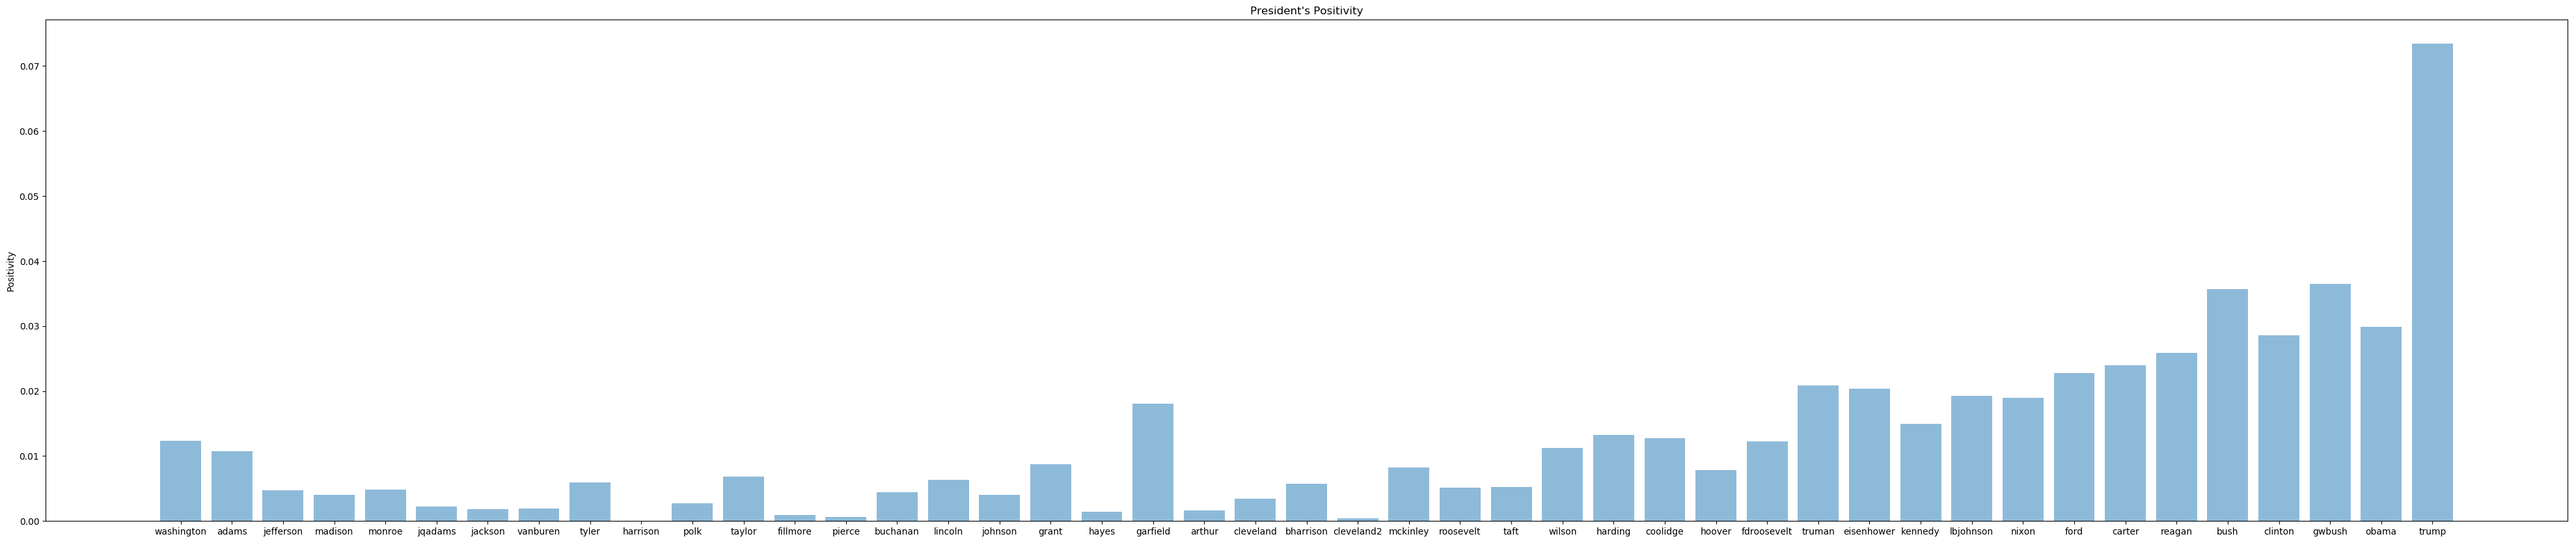

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(50, 10))

keys = pres_sentiments.keys()
y_pos = np.arange(len(keys))
values = pres_sentiments.values()
 
plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, keys)
plt.ylabel('Positivity')
plt.title("President's Positivity")
 
plt.show()